In [1]:
import os
import sys
import copy
import math
import torch
import random
import syft as sy
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import OrderedDict
sys.path.append(os.getcwd()+'/assistive_functions')

from SMWrapper import SMWrapper
from household import Household, SyNet
from load_data import get_data_of_a_person
from construct_dataset import construct_dataset
from sklearn.model_selection import train_test_split

random.seed(30)
np.random.seed(30)

In [2]:
# candidate lags
def get_lags(step_ahead, num_days=np.array([0,1,7])):
    lags = []
    for i in num_days:
        lags = lags + [48*i, 48*i+1, 48*i+2]
    lags = [x-step_ahead+1 for x in lags if x>=step_ahead]
    return lags

def connect_to_households(household_options):
    # get candidate houses from the selected group
    path = os.getcwd()+"/input/informations_households.csv.xls"
    data = pd.read_csv(path)
    # filter by group
    candidates = data.loc[data.Acorn==household_options['group']]
    # filter by tariff 
    candidates = candidates.loc[candidates.stdorToU==household_options['stdorToU']]
    # print(candidates)    
    # TODO: shuffle
    households=[]
    step_ahead=1

    # create households
    needed = household_options['num_households']
    num = 0
    while needed>0:
        # check if there are enough households
        if num>=len(candidates):
            num_households = len(households)
            print('[Warning] could not find enough households')
            print('[Warning] changed number of households to ' + str(num_households))
        # get household
        household = Household(house_id=candidates.LCLid.iloc[num],
                               block_num=candidates.file.iloc[num])
        # load data with regression options
        household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options)
        if len(household.y) > 0:
            households.append(household)
            needed = needed-1
        # search next
        num = num+1

    print('\n[INFO] Connected to ' + str(len(households)) + ' households')
    return households

### Connect to households

In [3]:
# number of devices and their group
num_households = 4
group="ACORN-L"
stdorToU="ToU"
household_options = {"num_households":num_households,
                    "group":group,
                    "stdorToU":stdorToU}

# regression options
options = {"dayparts":[],
           "resolution":60,
           "remove_holiday":True,
           "filt_days":['Tuesday'], 
           "replacement_method":'week_before',
           "feat_cols":['hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'temperature_hourly']}
step_ahead=1

households = connect_to_households(household_options)

# construct dataset
for household in households:
    household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options)
    household.train_test_split(test_frac=0.25)


[INFO] Connected to 4 households


# 1. Training Algorithms
## 1.1 Distributed Training

Problem setup:
* Each household has its' own local private dataset
* A server aims at training a shared model for all households
* The server does not have direct access to households' local datasets
* The server can ask households to run a learning algorithm localy and send back results

Algorithm: at each iteration,
* The server sends an initial model, a training method (Adam or SGD), and number of iterations (mini-batch size) to all households
* The households follow training instructions to fit the received model on their local datasets 
* Each households submits the change in the initial model parameters to the server
* The server collects parameter updates from all households, weights them by the training set size of the households local dataset divided by total training size owned by all households, and aggregates all changes
* The aggregated parameters updates calculated by combining parameter updates from individual households is used to build the model at this iteration

In [4]:
def print_param(model, message=''):
    with np.printoptions(precision=3, suppress=True):
        print(message+' model: \nbias = ' + 
              str(model.state_dict()['linear.bias'].numpy()[0]) +
              ', \nweights = ' + 
              str(model.state_dict()['linear.weight'].numpy().flatten()))
    return
        
        
def distributed_train(households, lr, mbsize, total_it, optim_method, **kwargs):
    '''
    optim_method: Adam or SGD
    '''
    random.seed(30)
    np.random.seed(30)
    torch.manual_seed(30)
    # find total samples
    tot_samp = 0
    for household in households:
        tot_samp = tot_samp + household.info['train_samples']
    # initialize model
    if 'init_state_dict' in kwargs:
        set_init = True
        init_state_dict = kwargs.get('init_state_dict')
    else:
        set_init = False
    # create an initial model with random parameters
    in_dim=households[0].info['num_features']
    model = SyNet(torch, in_dim=in_dim, out_dim=1)
    if set_init:
        for key, value in init_state_dict.items():
            model.state_dict()[key].copy_(value)
        print_param(model, 'Initial DA ')
    # create optimizer
    if optim_method=='Adam':
        optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    else:
        if optim_method=='SGD':
            optim = torch.optim.SGD(params=model.parameters(), momentum=0, lr=lr)
        else:
            print('Unsupported optimization method')
            return
    # iterate
    for i in np.arange(math.floor(total_it/mbsize)):
        # initialize param update
        cur_state_dict=copy.deepcopy(model.state_dict())
        cur_weight = model.state_dict()['linear.weight'].numpy().flatten()
        cur_bias = model.state_dict()['linear.bias'].numpy()
        delta_bias = np.zeros(1)
        delta_weight = np.zeros(in_dim)
        # run minibatch SGD for each household
        for household in households:
            # run minibatch SGD and get update in parameters
            db, dw = household.minibatch_SGD(model=model,optim=optim, mbsize=mbsize, verbose=False)
            # aggregate updates
            delta_bias  = db*household.info['train_samples']/tot_samp + delta_bias
            delta_weight= dw*household.info['train_samples']/tot_samp + delta_weight
            # reset model
            for key, value in cur_state_dict.items():
                model.state_dict()[key].copy_(value)
        # update model
        new_bias = cur_bias + delta_bias/len(households)
        new_bias = torch.tensor(new_bias)
        new_weight = cur_weight + delta_weight/len(households)
        new_weight = torch.tensor(new_weight.reshape((1,len(new_weight))))
        model.state_dict()['linear.weight'].copy_(new_weight)
        model.state_dict()['linear.bias'].copy_(new_bias)
        #print_param(model, 'Iteration ' + str(i) + ' ')

        #print(' ')
    # print trained parameters
    print_param(model, 'Trained DA ')
    return model

## 1.2 Central Training
Problem setup:
* Training data from all households is available simultaneously at a data center 

Algorithm:
* Training datasets from all households are augmented into a single matrix
* Training iterations are executed on the augmented dataset

In [18]:
def central_train(households, optim_method, lr, total_it, **kwargs):
    random.seed(30)
    np.random.seed(30)
    torch.manual_seed(30)
    # Augment training datasets
    for h_ind, household in enumerate(households):
        if h_ind==0:
            X_train_aug = households[0].X_train
            y_train_aug = households[0].y_train
        else:
            X_train_aug = np.concatenate((household.X_train, X_train_aug), axis=0)
            y_train_aug = np.concatenate((household.y_train, y_train_aug), axis=0)
    # shuffle
    #X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=0)
    if 'init_state_dict' in kwargs:
        set_init = True
        init_state_dict = kwargs.get('init_state_dict')
    else:
        set_init = False
    # create an initial model with random parameters
    in_dim=households[0].info['num_features']
    model = SyNet(torch, in_dim=in_dim, out_dim=1)
    if set_init:
        for key, value in init_state_dict.items():
            model.state_dict()[key].copy_(value)
        #print_param(model, 'Initial CA ')
    # create optimizer
    if optim_method=='Adam':
        optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    else:
        if optim_method=='SGD':
            optim = torch.optim.SGD(params=model.parameters(), momentum=0, lr=lr)
        else:
            print('Unsupported optimization method')
            return
    # iterate
    for i in range(total_it):
        optim.zero_grad()
        # predict
        output = model(torch.FloatTensor(X_train_aug))
        # calculate loss
        loss = torch.nn.functional.mse_loss(output, torch.FloatTensor(y_train_aug.reshape(-1, 1)))
        loss.backward()
        optim.step()
        #print("Epoch ", i, " train loss", loss.item())

    # print trained parameters
    print_param(model, 'Trained CA ')
    return model

# 2 Sanity Check
This section is for checking if the distributed Adam algorithm works correctly. 
## 2.1 Single Household Check
First, we use only one household and fit a linear regression model with two methods: 1) directly using Adam on the local data of this household, 2) using the distributed Adam by only one household. If initiated at the same parameters, both methods return the same weights and bias. 

In [19]:
lr = 0.1
mbsize = 2
total_it = 400

# create an initial model with random parameters
model = SyNet(torch, in_dim=household.info['num_features'], out_dim=1)
init_state_dict = copy.deepcopy(model.state_dict())
  
# set training data
households[0].train_test_split(test_frac=0.25)    

# METHOD 1
household = households[0]
print('\nMethod 1')
household.fit_personal_model(method='Adam', lr=lr, iterations=total_it, init_state_dict=init_state_dict)
model_lr = household.personal_lr
print_param(model_lr, 'personal')

# METHOD 2
print('\nMethod 2')
model_da = distributed_train([household], optim_method='Adam', 
                             lr=lr, mbsize=mbsize, total_it=total_it, 
                             init_state_dict=init_state_dict)

# Compare
tol = 1e-3
dif_b = np.abs(model_da.state_dict()['linear.bias'].numpy()-model_lr.state_dict()['linear.bias'].numpy())
dif_w = np.abs(model_da.state_dict()['linear.weight'].numpy().flatten()-model_lr.state_dict()['linear.weight'].numpy().flatten())
if np.all(dif_b<tol) and np.all(dif_w<tol):
    print('\nSingle household check was successful.')
else:
    print('\nSingle household check failed.')


Method 1
personal model: 
bias = 0.15443523, 
weights = [-0.039 -0.01  -0.017 -0.002 -0.063  1.937  0.176  0.532 -0.043 -0.134
  0.057  0.042 -0.042]

Method 2
Initial DA  model: 
bias = 0.045194328, 
weights = [-0.18  -0.087  0.243 -0.254 -0.215  0.109  0.209 -0.102 -0.112  0.157
  0.085 -0.043 -0.103]
Trained DA  model: 
bias = 0.1544352, 
weights = [-0.039 -0.01  -0.017 -0.002 -0.063  1.937  0.176  0.532 -0.043 -0.134
  0.057  0.042 -0.042]

Single household check was successful.


## 2.2 Multiple Households Check
To assess the correctness of the distributed Adam algorithm, we compare it with the central learning scenario. In the central algorithm, we assume that the training data from all households is available simultaneously and run the Adam iterations on the augmented dataset.

In [22]:
lr = 0.1
mbsize = 1
total_it = 1000
# create an initial model with random parameters
model = SyNet(torch, in_dim=household.info['num_features'], out_dim=1)
init_state_dict = copy.deepcopy(model.state_dict())

# METHOD 1
print('\nMethod 1')
model_ca = central_train(households, optim_method='Adam', lr=lr, total_it=total_it, init_state_dict=init_state_dict)

# METHOD 2
print('\nMethod 2')
model_da = distributed_train(households, lr=lr, total_it=total_it, mbsize=mbsize, optim_method='Adam', init_state_dict=init_state_dict)

# Compare
tol = 1e-2
model1 = model_ca
model2 = model_da
dif_b = np.abs(model1.state_dict()['linear.bias'].numpy()-model2.state_dict()['linear.bias'].numpy())
dif_w = np.abs(model1.state_dict()['linear.weight'].numpy().flatten()-model2.state_dict()['linear.weight'].numpy().flatten())
if np.all(dif_b<tol) and np.all(dif_w<tol):
    print('Models match with ' + str(tol) + 'precision')
else:
    print('Models do not match with ' + str(tol) + 'precision')


Method 1
Trained CA  model: 
bias = 0.15088539, 
weights = [-0.059 -0.006 -0.017  0.    -0.073  0.875  0.017  0.244 -0.012  0.098
  0.684 -0.016 -0.095]

Method 2
Initial DA  model: 
bias = 0.045194328, 
weights = [-0.18  -0.087  0.243 -0.254 -0.215  0.109  0.209 -0.102 -0.112  0.157
  0.085 -0.043 -0.103]
Trained DA  model: 
bias = 0.1526039, 
weights = [-0.059 -0.007 -0.017 -0.    -0.075  0.885  0.021  0.245 -0.012  0.095
  0.677 -0.02  -0.098]
Models match


# Performance Test

Trained CA  model: 
bias = 0.15088539, 
weights = [-0.059 -0.006 -0.017  0.    -0.073  0.875  0.017  0.244 -0.012  0.098
  0.684 -0.016 -0.095]
Initial DA  model: 
bias = 0.045194328, 
weights = [-0.18  -0.087  0.243 -0.254 -0.215  0.109  0.209 -0.102 -0.112  0.157
  0.085 -0.043 -0.103]
Trained DA  model: 
bias = 0.18808135, 
weights = [-0.071 -0.006 -0.019 -0.003 -0.072  0.827  0.001  0.25  -0.003  0.065
  0.633 -0.027 -0.092]


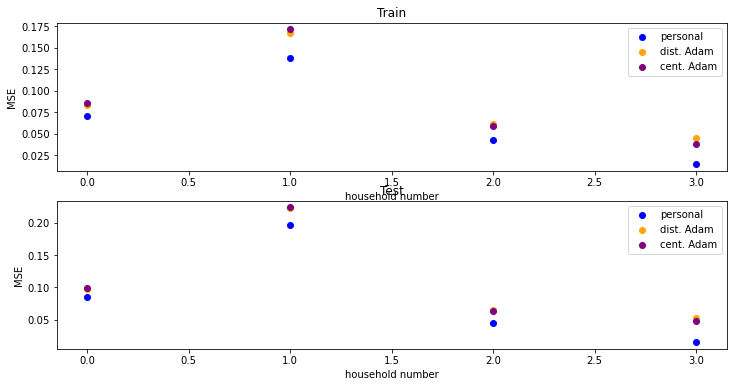

In [23]:
# parameters
lr = 0.1
mbsize = 10
total_it = 1000
in_dim = households[0].info['num_features']
init_model = SyNet(torch, in_dim=in_dim, out_dim=1)
init_state_dict = init_model.state_dict()

# train central adam
model_ca = central_train(households, optim_method='Adam', 
                         lr=lr, total_it=total_it, init_state_dict=init_state_dict)

# train distributed adam
model_da = distributed_train(households, optim_method='Adam', 
                             lr=lr, mbsize=mbsize, total_it=total_it, init_state_dict=init_state_dict)

mse_train_pr = np.zeros(num_households)
mse_train_da = np.zeros(num_households)
mse_train_ca = np.zeros(num_households)
mse_test_pr = np.zeros(num_households)
mse_test_da = np.zeros(num_households)
mse_test_ca = np.zeros(num_households)

for h_ind, household in enumerate(households):
    # train personal model 
    household.fit_personal_model(method='Adam', lr=lr, iterations=total_it, init_state_dict=init_state_dict)
    res = household.evaluate_model(method='Adam')
    mse_train_pr[h_ind] = res['MSE_train']
    mse_test_pr[h_ind] = res['MSE_test']
    # test distributed adam
    res = household.evaluate_model(method='Adam', model=model_da)
    mse_train_da[h_ind] = res['MSE_train']
    mse_test_da[h_ind] = res['MSE_test']
    # test central adam
    res = household.evaluate_model(method='Adam', model=model_ca)
    mse_train_ca[h_ind] = res['MSE_train']
    mse_test_ca[h_ind] = res['MSE_test']
    
fig,axs = plt.subplots(2,1,figsize=(12,6))
axs[0].scatter(np.arange(num_households), mse_train_pr, color='blue', label='personal')
axs[0].scatter(np.arange(num_households), mse_train_da, color='orange', label='dist. Adam')
axs[0].scatter(np.arange(num_households), mse_train_ca, color='purple', label='cent. Adam')
axs[0].set_title('Train')
axs[1].scatter(np.arange(num_households), mse_test_pr, color='blue', label='personal')
axs[1].scatter(np.arange(num_households), mse_test_da, color='orange', label='dist. Adam')
axs[1].scatter(np.arange(num_households), mse_test_ca, color='purple', label='cent. Adam')
axs[1].set_title('Test')
for ax in axs:
    ax.legend()
    ax.set_xlabel('household number')
    ax.set_ylabel('MSE')
    